<a href="https://colab.research.google.com/github/Lipinor/deep_learning_cbpf/blob/master/tarefa_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import os
import PIL
import random
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
data_file_path = '/content/drive/My Drive/Deep_Learning/data/tarefa_4/dataset_images_minitest.csv'
df = pd.read_csv(data_file_path,sep='\t')

Now let's separate the dataframe.

In [6]:
df_graduation = df[df['category'] == 'graduation']
df_picnic = df[df['category'] == 'picnic']
df_meeting = df[df['category'] == 'meeting']

print(f"Number of graduation images: {len(df_graduation)}")
print(f"Number of picnic images: {len(df_picnic)}")
print(f"Number of meeting images: {len(df_meeting)}")
print(f"Total number of samples: {len(df_graduation)+len(df_picnic)+len(df_meeting)}")

Number of graduation images: 6992
Number of picnic images: 6995
Number of meeting images: 7000
Total number of samples: 20987


Validation split...

In [9]:
# Choose the percentage of the data that you want for your 
# validation, here I choose 30%.
validation_split = 0.3

#split for graduation samples
val_samples_graduation = int(validation_split*len(df_graduation))

df_graduation_train = df_graduation.iloc[val_samples_graduation:] 
df_graduation_val = df_graduation.iloc[:val_samples_graduation] 

#split for picnic samples
val_samples_picnic = int(validation_split*len(df_picnic))

df_picnic_train = df_picnic.iloc[val_samples_picnic:] 
df_picnic_val = df_picnic.iloc[:val_samples_picnic] 

#split for meeting samples
val_samples_meeting = int(validation_split*len(df_meeting))

df_meeting_train = df_meeting.iloc[val_samples_meeting:] 
df_meeting_val = df_meeting.iloc[:val_samples_meeting] 

print(f"Number of training samples: {len(df_graduation_train)+len(df_picnic_train)+len(df_meeting_train)}")
print(f"Number of validation samples: {len(df_graduation_val)+len(df_picnic_val)+len(df_meeting_val)}")

Number of training samples: 14692
Number of validation samples: 6295


In [10]:
train_frames = [df_graduation_train, df_picnic_train, df_meeting_train]
val_frames = [df_graduation_val, df_picnic_val, df_meeting_val]

train_df = pd.concat(train_frames)
val_df = pd.concat(val_frames)

Preparing the images...

In [12]:
!pip install unrar
!unrar x "/content/drive/My Drive/Deep_Learning/data/tarefa_4/data_folder.rar" 

A saída de streaming foi truncada nas últimas 5000 linhas.
Extracting  data_folder/6929597574_dc5dd8b10b.jpg                         60%  OK 
Extracting  data_folder/6931532444_f3f1db0b6e.jpg                         60%  OK 
Extracting  data_folder/6938682540_7697a17902.jpg                         60%  OK 
Extracting  data_folder/6938683414_07c2935433.jpg                         60%  OK 
Extracting  data_folder/6938684226_d38a72c32d.jpg                         60%  OK 
Extracting  data_folder/6938688566_4a72e848f7.jpg                         60%  OK 
Extracting  data_folder/6938696766_abb5dd7907.jpg                         60%  OK 
Extracting  data_folder/6938697544_ea0a40b970.jpg                         60%  OK 
Extracting  data_folder/6938704602_024838879c.jpg                         60%  OK 
Extracting  data_folder/6938705546_816070e2b8.jpg                         60%  OK 
Extracting  data_fold

## Building the Model



In [46]:
images_path = "/content/data_folder"

batch_size = 36
img_size = (128,128)

#train_datagen = ImageDataGenerator(rescale=1./255)

train_datagen = ImageDataGenerator(
rescale=1./255,
rotation_range=40,
width_shift_range=0.2,
height_shift_range=0.2,
shear_range=0.2,
zoom_range=0.2,
horizontal_flip=True,
validation_split=0.20)

print("Training dataset:")
train_generator = train_datagen.flow_from_dataframe(
        dataframe= train_df,
        directory= images_path,
        x_col="filename",
        y_col="category",
        batch_size=batch_size,
        seed=42,
        shuffle=True,
        class_mode="categorical",
        target_size=img_size) 

val_datagen = ImageDataGenerator(rescale=1./255)

print("Validation dataset:")
valid_generator = val_datagen.flow_from_dataframe(
        dataframe= val_df,
        directory= images_path,
        x_col="filename",
        y_col="category",
        batch_size=batch_size,
        seed=42,
        shuffle=True,
        class_mode="categorical",
        target_size=img_size)


Training dataset:
Found 14692 validated image filenames belonging to 3 classes.
Validation dataset:
Found 6295 validated image filenames belonging to 3 classes.


# Model compilation

In [47]:
from keras import layers
from keras import models

'''
num_filters = 8
filter_size = 3
pool_size = 2

model = Sequential([
  Conv2D(num_filters, filter_size, input_shape=(32, 32, 3)),
  MaxPooling2D(pool_size=pool_size),
  Dropout(0.3),
  Flatten(),
  Dense(3, activation='softmax'),
])
'''

num_classes = 3

model = Sequential([
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.3),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.3),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

'''
#lr original: 0.0001
model.compile(optimizers.RMSprop(lr=0.0001, decay=1e-6),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

'''
# Compile the model.
model.compile(
  'adam',
  loss='categorical_crossentropy',
  metrics=['accuracy'],
)



# Model fitting

In [48]:
'''
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

history = model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=10
)

'''
history = model.fit_generator(
train_generator,
steps_per_epoch=100,
epochs=10,
validation_data=valid_generator,
validation_steps=50)


Epoch 1/10
100/100 [==============================] - 102s 1s/step - loss: 1.2920 - accuracy: 0.3436 - val_loss: 1.0697 - val_accuracy: 0.3761
Epoch 2/10
100/100 [==============================] - 106s 1s/step - loss: 1.0574 - accuracy: 0.4300 - val_loss: 1.0257 - val_accuracy: 0.5111
Epoch 3/10
100/100 [==============================] - 104s 1s/step - loss: 1.0207 - accuracy: 0.4756 - val_loss: 1.0186 - val_accuracy: 0.4683
Epoch 4/10
100/100 [==============================] - 102s 1s/step - loss: 1.0066 - accuracy: 0.5036 - val_loss: 0.9834 - val_accuracy: 0.5217
Epoch 5/10
100/100 [==============================] - 105s 1s/step - loss: 1.0041 - accuracy: 0.5053 - val_loss: 0.9844 - val_accuracy: 0.5311
Epoch 6/10
100/100 [==============================] - 102s 1s/step - loss: 0.9819 - accuracy: 0.5169 - val_loss: 0.9772 - val_accuracy: 0.5078
Epoch 7/10
100/100 [==============================] - 100s 1s/step - loss: 0.9326 - accuracy: 0.5552 - val_loss: 0.9052 - val_accuracy: 0.5817

In [49]:
#@title Função para os plots (la_plots(history))
def la_plots(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    #Epochs
    epochs = range(len(val_loss))

    # Plotting loss
    
    COLOR = 'white'
    plt.rcParams['axes.labelcolor'] = COLOR
    plt.rcParams['xtick.color'] = COLOR
    plt.rcParams['ytick.color'] = COLOR
    

    fig1 = plt.figure(figsize=(8,5))
    gs1 = fig1.add_gridspec(1, 1)
    ax1 = fig1.add_subplot(gs1[0, 0])

    ax1.plot(epochs, loss, 'r-o', label='Training')
    ax1.plot(epochs, val_loss, 'b-o', label='Validation')
    ax1.set_xlabel('Epochs', size=16)
    ax1.set_ylabel('Loss', size=16)
    #ax1.set_yscale('log')
    ax1.legend()
    plt.show()

    # Plotting accuracy metric

    fig2 = plt.figure(figsize=(8,5))
    gs2 = fig2.add_gridspec(1, 1)
    ax2 = fig2.add_subplot(gs2[0, 0])

    ax2.plot(epochs, accuracy, 'r-o', label='Training')
    ax2.plot(epochs, val_accuracy, 'b-o', label='Validation')
    ax2.set_xlabel('Epochs', size=16)
    ax2.set_ylabel('Accuracy', size=16)
    #ax2.set_yscale('log')
    ax2.legend()
    plt.show()

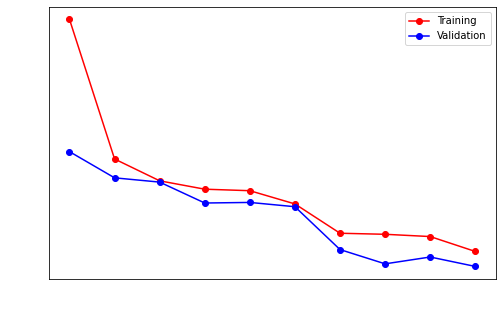

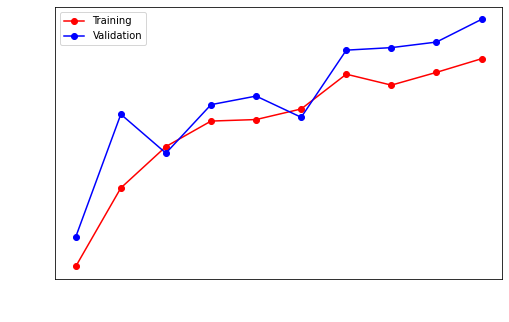

In [50]:
la_plots(history)